# Biomassters Data Exploration and Pre-Processing

1. Visualize Sentinel data and AGBM data 
2. Select best month of data for each chipid
3. Research Qs

### Download Data 

Download data with directions at https://www.drivendata.org/competitions/99/biomass-estimation/data/ 

Keep data in same directories for use with these notebooks

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import rasterio
from torchgeo.transforms import indices
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)  # our rasters are not georeferenced
warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

### Import local modules

In [20]:
import dataloading as dl
import transforms as tf
from preprocessing import calc_quality_scores
from utils import plot_by_tile_index, plot_by_id_month

### Set Device

In [21]:
try:
    if torch.backends.mps.is_available(): # Mac M1/M2
        device = torch.device('mps')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
except AttributeError:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

print(f'device: {device}')

device: cuda


### Data directories

In [22]:
bucket_name = None

train_folder = 'train_features'
test_folder = 'test_features'
train_labels = 'train_agbm'

In [23]:
if not bucket_name:
    dir_tiles = 'data/train_features'
    dir_target = 'data/train_agbm'
    dir_test = 'data/test_features'
else:
    dir_tiles = 'gs://biomassters-data/train_features/' 
    dir_target = 'gs://biomassters-data/train_agbm/'
    dir_test = 'gs://biomassters-data/test_features/'

### Transforms

In [24]:
transforms = nn.Sequential(
    indices.AppendNDVI(index_nir=6, index_red=2), # NDVI, index 15
    tf.AppendRatioAB(index_a=11, index_b=12),  # VV/VH Ascending, index 16
)

In [25]:
if bucket_name:
    import os
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'gcp-credentials.json'

In [26]:
max_chips=None  # set how many data tiles to load; if tile_file=None then this limits tiles, not chips (multiple tiles per chipid)
dataset = dl.SentinelDataset(tile_file=None,
                             dir_tiles=dir_tiles,
                             dir_target=dir_target,
                             max_chips=max_chips,
                             transform=transforms,
                             device=device,
                             gcp_bucket_name=bucket_name,
                             scale=False
                             )

## DataViz 

In [27]:
channel_map = {
    0: 'S2-B2: Blue-10m',
    1: 'S2-B3: Green-10m',
    2: 'S2-B4: Red-10m',
    3: 'S2-B5: VegRed-704nm-20m',
    4: 'S2-B6: VegRed-740nm-20m',
    5: 'S2-B7: VegRed-780nm-20m',
    6: 'S2-B8: NIR-833nm-10m',
    7: 'S2-B8A: NarrowNIR-864nm-20m',
    8: 'S2-B11: SWIR-1610nm-20m',
    9: 'S2-B12: SWIR-2200nm-20m',
    10: 'S2-CLP: CloudProb-160m',
    11: 'S1-VV-Asc: Cband-10m',
    12: 'S1-VH-Asc: Cband-10m',
    13: 'S1-VV-Desc: Cband-10m',
    14: 'S1-VH-Desc: Cband-10m',
    15: 'S2-NDVI: (NIR-Red)/(NIR+Red) 10m',
    16: 'S1-VV/VH-Asc: Cband-10m'
}
month_map = {
    0: 'Sep', 1: 'Oct', 2: 'Nov', 3: 'Dec',
    4: 'Jan', 5: 'Feb', 6: 'Mar', 7: 'Apr',
    8: 'May', 9: 'Jun', 10: 'Jul', 11: 'Aug'
}

### Specify which channels to plot

In [28]:
plot_channels = {
    0: {'s2_rgb_idxs': [2, 1, 0], 'title': 'RGB'}, # RGB image, special case 
    1: {'data': 'target', 'title': 'AGBM', 'LogNorm': True}, # AGBM target data, special case 
    2: {'channel_idx': 6},  # general case of visualizing by channel_index 
    3: {'channel_idx': 15},
    4: {'channel_idx': 10},
    5: {'channel_idx': 12}, 
    6: {'channel_idx': 16},
    7: {'s1_rgb_idxs': [11, 12, 16], 'title': 'SAR-RGB: VV,VH,VV/VH'}, # SAR psuedo-RGB, special case 
}

### Plot RGB, AGBM, and channels by tile index 

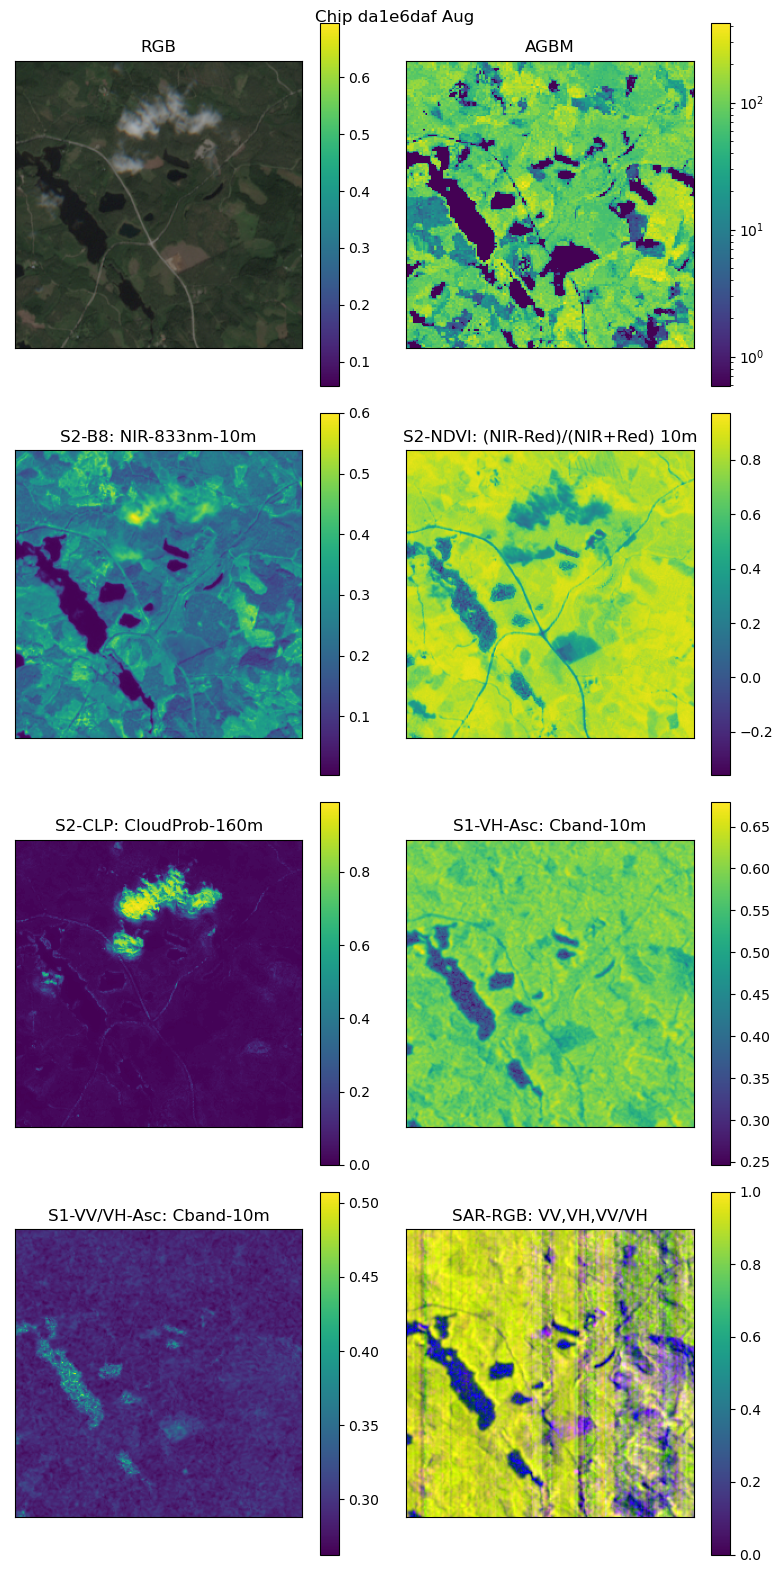

In [29]:
np.random.seed(2)
tile_idx = np.random.choice(len(dataset)) 
plot_by_tile_index(dataset, tile_idx, plot_channels, channel_map)

## Select Best Month of Data for each ChipID
The Sentinel data is pretty messy, even with the curation provided by the Biomassters competition, so here we select a single month of data to be used for model training and prediction for each ChipID.

The Sentinel-1 SAR data is much more consitent than the Sentinel-2 optical data, so the basic approach is to use the SAR data as gold standard and choose months when the optical data most closely matches it. Specifically, we compare standardized data from of the NDVI index (clamped at 0 min) with the VH channel. 

Furthermore, the resulted comparison is weighted by the amount of clouds that were present as that reduces the useful information that can be obtained from Sentinel-2 bands. At last, a quick and dirty metric is used to catch images with information loss, which usually results in images with a big patch of data with the same value.

In [9]:
def find_best_month_score(scores_df: pd.DataFrame, high_thresh: float = 0.95, min_thresh: float = 0.9) -> int:
    '''Calculate and return the best band score per heuristics
    '''
    scores_df = scores_df.copy()
    scores_df['weighted_score'] = scores_df.score - (0.5 * scores_df.cloud_ratio) - 0.5 * scores_df.biggest_patch_ratio
    scores_df['weighted_score'] = np.where(scores_df.weighted_score>0, scores_df.weighted_score, 0.)
    scores_df.sort_values('weighted_score', ascending=False, inplace=True)
    return scores_df.iloc[0].month, scores_df.iloc[0].weighted_score

def find_best_months(df_scores):
    
    out_df = df_scores.chipid.drop_duplicates().to_frame()
    out_df[['month','score']] = np.vstack(df_scores.groupby('chipid').progress_apply(find_best_month_score).values)
    return out_df

### First find the "quality" score per month per chip id

In [25]:
df_scores = calc_quality_scores(dataset)
df_scores.to_csv('data/df_scores.csv', index=None)

  0%|          | 0/84810 [00:00<?, ?it/s]

In [5]:
df_scores = pd.read_csv('data/df_scores.csv')

### Select the best month

In [12]:
df_best = find_best_months(df_scores)

  0%|          | 0/8689 [00:00<?, ?it/s]

#### Sanity Check best month

In [17]:
chipid, month = df_best[['chipid','month']].values[0]

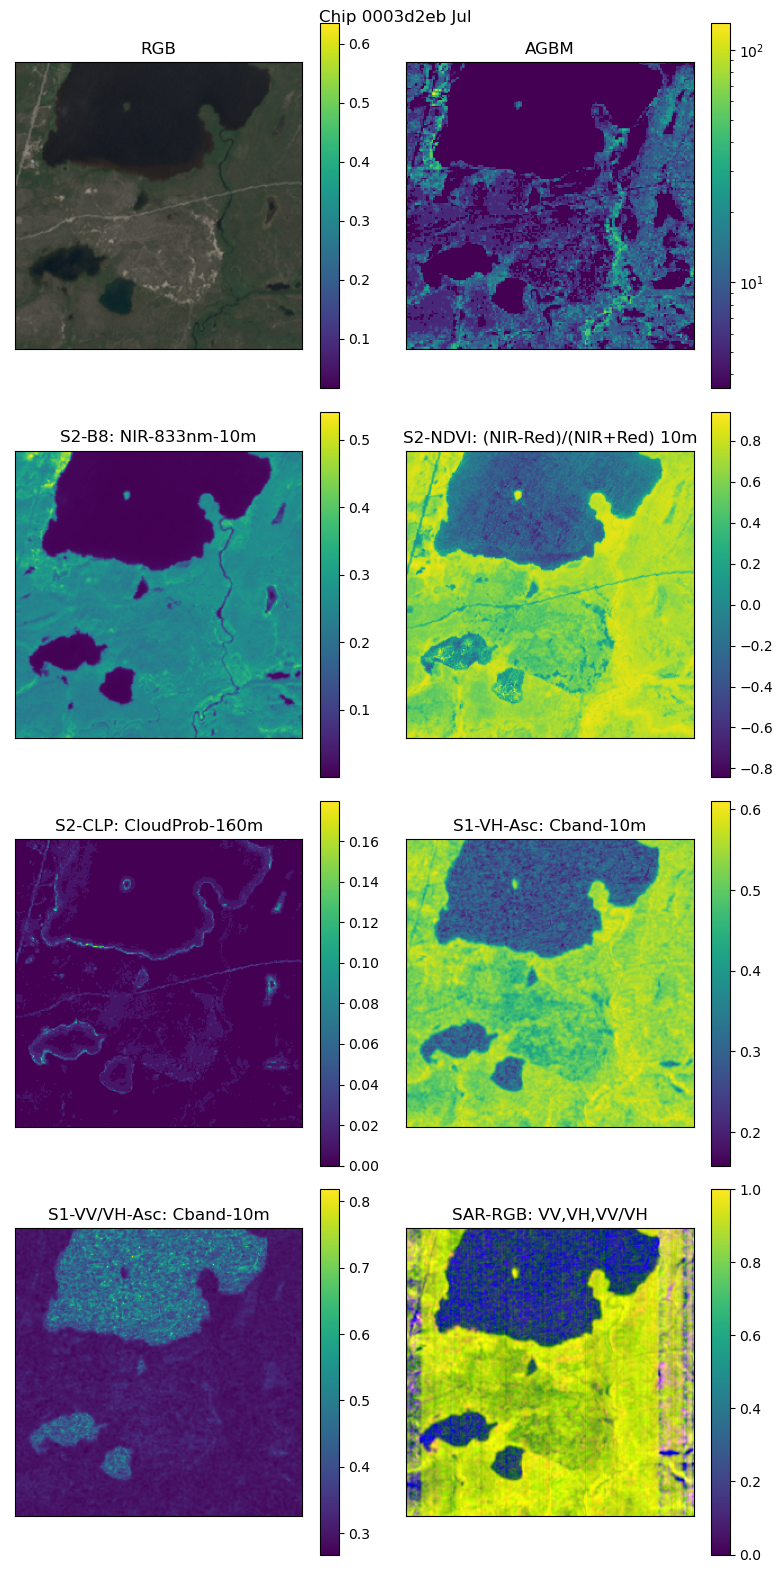

In [30]:
plot_by_id_month(dataset, chipid, month, plot_channels, channel_map)

#### Save for use with training workflow

In [45]:

df_best.to_csv('data/TILE_LIST_BEST_MONTHS.csv')

  0%|          | 0/8689 [00:00<?, ?it/s]

### Do same for test data, i.e., select best month for generating predictions 

In [46]:
max_chips=None
dataset_test = dl.SentinelDataset(tile_file=None,
                                dir_tiles=dir_test,
                                dir_target=None,
                                max_chips=max_chips,
                                transform=transforms,   
                                device=device,
                                gcp_bucket_name=bucket_name,
                                scale=False
                                )

In [47]:
df_scores_test = calc_quality_scores(dataset_test)

  0%|          | 0/30072 [00:00<?, ?it/s]

In [48]:
df_best_test = find_best_months(df_scores_test)

  0%|          | 0/2773 [00:00<?, ?it/s]

In [49]:
df_best_test.to_csv('data/TILE_LIST_BEST_MONTHS_TEST.csv')